# Задача 1. Обнаружение фальшивых новостей

## Условия

 Задача -  используя библиотеку sklearn построить модель классического машинного обучения, которая может с высокой точностью более 90% определять, является ли новость реальной (REAL） или фальшивой（FAKE).

Датасет для обучения: https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv

## Решение

### Импорты

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Функции

In [ ]:
import re

# делаем текст более однородным - убираем пунктуацию и приводим к нижнему регистру
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score

# Вспомогательная функция для разделения датасета на выборки
def split_to_train_val_test(df, col, test_size=0.2, val_size=0.2, random_state=42):

    X_temp, X_test, y_temp, y_test = train_test_split(
        df[col], y, test_size=test_size, stratify=y, random_state=random_state
    )

    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Основная функция векторизации, обучения и оценки точности
def evaluate_column(df,max_df_val, col_name):
    # Засекаем время
    start_time = time.time()
    # Отделяем данные для обучения
    X_train, X_val, X_test, y_train, y_val, y_test = split_to_train_val_test(df, col_name)

    # Очищаем текст каждой выборки
    X_train_clean = X_train.apply(clean_text)
    X_val_clean = X_val.apply(clean_text)
    X_test_clean = X_test.apply(clean_text)

    # Инициализируем векторизатор
    vectorizer = TfidfVectorizer(max_df=max_df_val)
    # Строим матрицу признаков для тренировочной части
    X_train_vec = vectorizer.fit_transform(X_train_clean)
    # Преобразуем тексты для валидационной и тестовой выборок
    X_val_vec = vectorizer.transform(X_val_clean)
    X_test_vec = vectorizer.transform(X_test_clean)

    # Модель
    model = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
    # Обучаем модель
    model.fit(X_train_vec, y_train)

    # Предсказания на всех выборках
    y_train_pred = model.predict(X_train_vec)
    y_val_pred = model.predict(X_val_vec)
    y_test_pred = model.predict(X_test_vec)

    # Собираем метрики
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_val = accuracy_score(y_val, y_val_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    train_time = time.time() - start_time

    return {
        "column": col_name,
        "max_df": max_df_val,
        "accuracy_train": acc_train,
        "accuracy_val": acc_val,
        "accuracy_test": acc_test,
        "train_time_sec": train_time
    }

### Изучаем датасет

In [ ]:
# Скачиваем датасет
!wget https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv

--2025-07-30 19:21:28--  https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/csv]
Saving to: ‘fake_news.csv’

fake_news.csv       100%[===================>]  29.27M  14.7MB/s    in 2.0s    

2025-07-30 19:21:31 (14.7 MB/s) - ‘fake_news.csv’ saved [30696129/30696129]



In [ ]:
# Открываем скачанный файл
df = pd.read_csv("./fake_news.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [ ]:
# Смотрим размерность датасета
df.shape

(6335, 4)

In [ ]:
# Изучаем первые 5 строк
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# Изучаем последние 5 строк
df.tail()

,Unnamed: 0,title,text,label
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


In [ ]:
# Проверяем на наличие нулевых или пропущенных значений
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


In [ ]:
# Изучаем количество уникальных меток и их соотношение
df.label.value_counts()

,count
label,
REAL,3171
FAKE,3164


## Подготавливаем датасет

Оценивать можно как по тексту новости, так и по заголовку. Проверю ещё вариант, когда оценивать будем новость вместе с заголовком.

In [ ]:
# Заменим названия классов на числа: FAKE -> 0, REAL -> 1
y = df['label'].map({'FAKE': 0, 'REAL': 1})

# Добавляем колонку, где будут заголовок и текст вместе
df["both"] = df["title"] + " " + df["text"]
cols = ["text", "title", "both"]

Так же важен параметр max_df - попробую взять несколько значений и сравнить

In [ ]:
results = []
max_df_values = [0.5, 0.7, 0.9]

## Обучение и оценка результатов

In [ ]:
for col in cols:
    for max_df_val in max_df_values:
        print(f"Обучение и оценка: столбец='{col}', max_df={max_df_val}")
        result = evaluate_column(df, max_df_val, col)
        results.append(result)

# Создаём DataFrame из списка словарей
results_df = pd.DataFrame(results)

# Покажем отсортированную таблицу по тестовой точности
print("\n Таблица результатов \n")
print(results_df[["column", "max_df", "accuracy_train", "accuracy_val", "accuracy_test", "train_time_sec"]]
      .sort_values(by="accuracy_test", ascending=False)
      .reset_index(drop=True))

best_row = results_df.loc[results_df['accuracy_test'].idxmax()]

Обучение и оценка: столбец='text', max_df=0.5
Обучение и оценка: столбец='text', max_df=0.7
Обучение и оценка: столбец='text', max_df=0.9
Обучение и оценка: столбец='title', max_df=0.5
Обучение и оценка: столбец='title', max_df=0.7
Обучение и оценка: столбец='title', max_df=0.9
Обучение и оценка: столбец='both', max_df=0.5
Обучение и оценка: столбец='both', max_df=0.7
Обучение и оценка: столбец='both', max_df=0.9

 Таблица результатов 

  column  max_df  accuracy_train  accuracy_val  accuracy_test  train_time_sec
0   both     0.9             1.0      0.935280       0.946330        5.571604
1   text     0.9             1.0      0.935280       0.940805        5.154391
2   both     0.5             1.0      0.937648       0.940016        6.043057
3   text     0.7             1.0      0.935280       0.940016        6.559024
4   both     0.7             1.0      0.936069       0.939227        5.124737
5   text     0.5             1.0      0.937648       0.935280        9.669708
6  title     

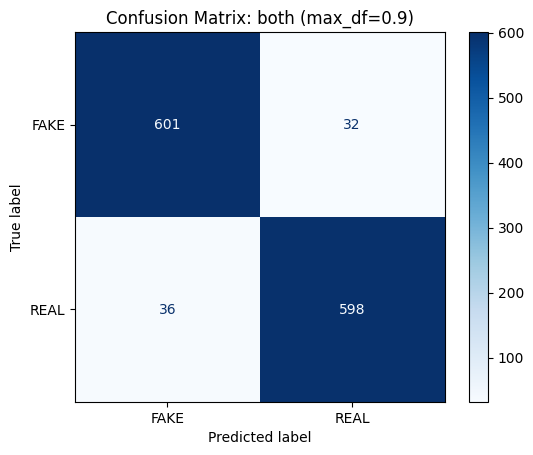

In [ ]:
# Повторяем предобработку и обучение на лучших параметрах:
X_train, X_val, X_test, y_train, y_val, y_test = split_to_train_val_test(df, best_row['column'])
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

vectorizer = TfidfVectorizer(max_df=best_row['max_df'])
X_train_vec = vectorizer.fit_transform(X_train_clean)
X_test_vec = vectorizer.transform(X_test_clean)
model = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
model.fit(X_train_vec, y_train)
y_test_pred = model.predict(X_test_vec)

# Визуализируем
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix: {best_row['column']} (max_df={best_row['max_df']})")
plt.show()